# Local-Global-Trend(LGT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

## Data

In [2]:
DATA_FILE = "./data/iclaims_example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## MAP Fit and Predict

In [8]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    sample_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True
)

In [9]:
%%time
lgt_map.fit(df=train_df)

CPU times: user 82.4 ms, sys: 10.2 ms, total: 92.5 ms
Wall time: 340 ms


In [10]:
print(lgt_map.aggregated_posteriors['map']['obs_sigma'], lgt_map.cauchy_sd)

[0.04206182] 0.45414060275121276


In [11]:
predicted_df = lgt_map.predict(df=test_df)

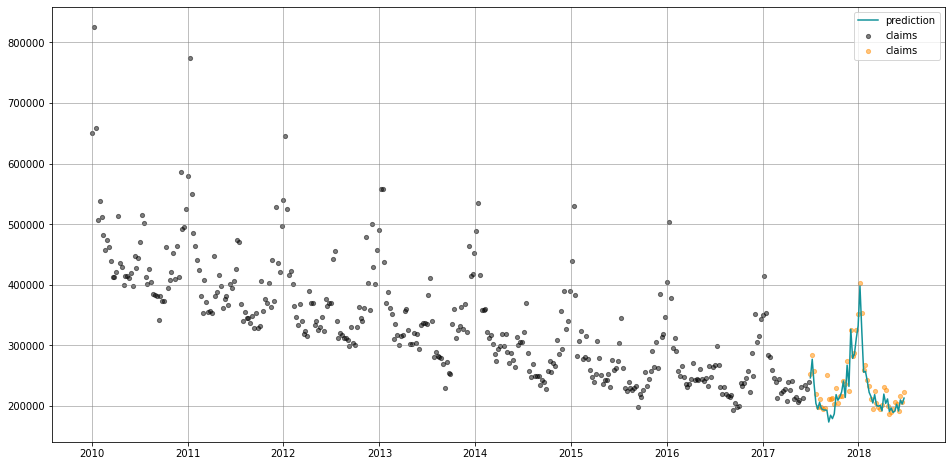

In [12]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [13]:
test_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
391,2017-07-02,252886,1.183973,1.099162,0.919307
392,2017-07-09,284329,1.222792,1.023357,1.025381
393,2017-07-16,257763,1.145154,1.061259,0.990023
394,2017-07-23,220455,1.125745,1.023357,1.025381
395,2017-07-30,198776,1.145154,1.042308,1.048953


## MCMC Fit and Predict

In [28]:
lgt_mcmc = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    sample_method='mcmc',
    predict_method='full',
    num_warmup=4000, 
    num_sample=500,
    n_bootstrap_draws=-1,
)

In [30]:
%%time
lgt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


31.4 s ± 518 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
predicted_df = lgt_mcmc.predict(df=test_df)

In [17]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,183334.335052,206727.185724,231389.237265
48,2018-06-03,173858.979350,193374.247644,216577.721837
49,2018-06-10,189317.968588,213133.453110,237608.149443
50,2018-06-17,182432.409691,205958.778289,231593.665105
51,2018-06-24,193863.366969,216040.880933,242058.125696


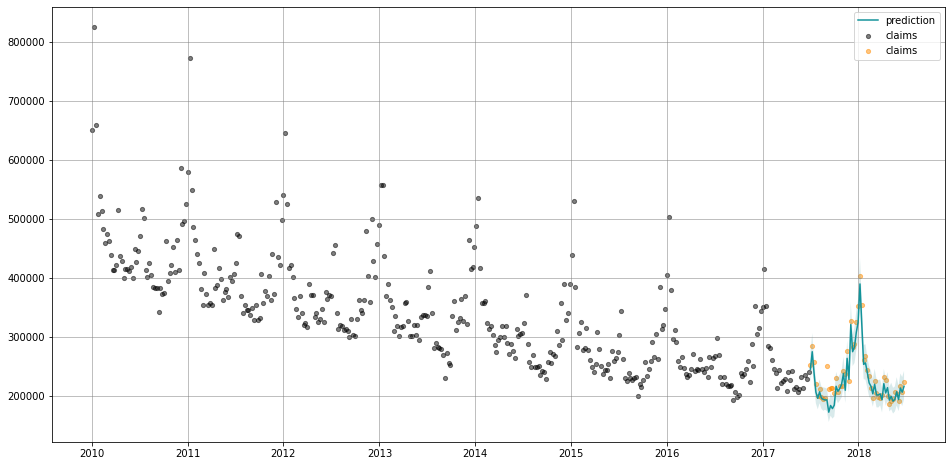

In [18]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mcmc.date_col, actual_col=lgt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit

In [19]:
lgt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    sample_method='mcmc',
    predict_method='mean',
    num_warmup=4000, 
    num_sample=500,
)

In [20]:
%%time
lgt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 220 ms, sys: 266 ms, total: 485 ms
Wall time: 33.2 s


In [21]:
predicted_df = lgt_mean.predict(df=test_df)

In [22]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,244089.873611
1,2017-07-09,274085.143969
2,2017-07-16,235692.977936
3,2017-07-23,203553.611993
4,2017-07-30,193501.495682


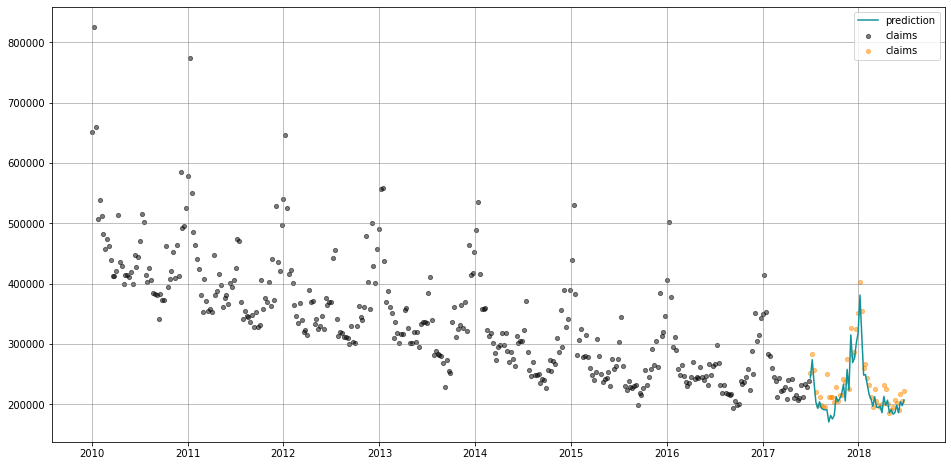

In [23]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors & Predict with Decomp

### Fit with Regressors

In [24]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    sample_method='map',
    predict_method='map',
)

In [25]:
%%time
lgt_reg_map.fit(df=train_df)

CPU times: user 289 ms, sys: 11.7 ms, total: 301 ms
Wall time: 305 ms


### Decompose Prediction

We can use `decompose=True` to decompose prediction into `trend`, `seasonality` and `regression` components. This command only works with point estimate.

In [26]:
# make prediction of past and future
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2010-01-03,651215.000000,495859.763610,1.337553,0.981871
1,2010-01-10,826239.822495,483793.170526,1.722632,0.991411
2,2010-01-17,650729.204467,482097.928420,1.370942,0.984568
3,2010-01-24,514285.397495,482032.863781,1.076930,0.990695
4,2010-01-31,530024.645986,479889.931428,1.122388,0.984037


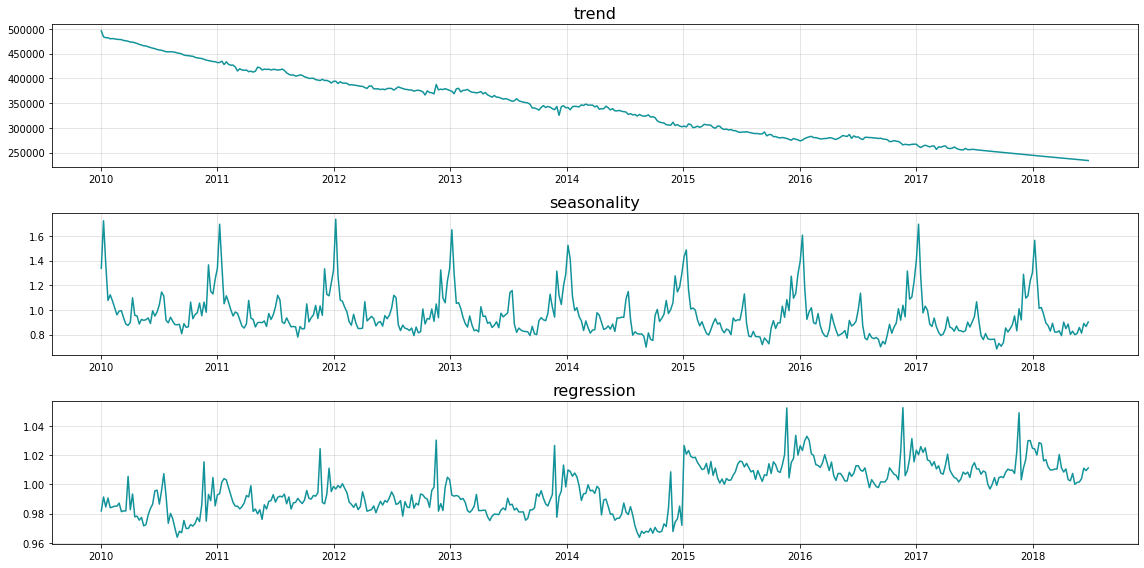

In [27]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')